This is still a redundant version. But it shows how to use the Tensorflow do the construction of a VAE model. I will come back later to do the revision.

In [0]:
import os
import scipy.misc
import numpy as np
import tensorflow as tf
import time
import math
import matplotlib.pyplot as plt

class VAE(object):
    def __init__(self, sess, image_size=28, batch_size=100, sample_size=100, z_dim=5, c_dim=1, device_name="cpu"):
        
        self.sess = sess
        self.batch_size = batch_size
        self.input_size = image_size
        self.sample_size = sample_size
        self.output_size = image_size
        self.print_step = 1

        self.z_dim = z_dim
        self.c_dim = 1

        self.dataset_name = 'mnist'
        self.device_name = device_name
        
        if self.device_name == "gpu":
            self.device_name = "/gpu:0"
        else:
            self.device_name = "/cpu:0"
        
        with tf.device(device_name):
            self.Network()

        self.saver = tf.train.Saver()
        
    def img2cell(self,images, col_num=25, margin=2):
        [num_images, size_h, size_w, n_channel] = images.shape
        row_num = int(math.ceil(num_images/col_num))
        saved_img = np.zeros(((row_num * size_h + margin * (row_num - 1)),
                              (col_num * size_w + margin * (col_num - 1)),n_channel), dtype=np.float32)
        for idx in range(num_images):
            ir = int(math.floor(idx / col_num))
            ic = idx % col_num
            saved_img[(size_h + margin) * ir:size_h + (size_h + margin) * ir,
                      (size_w + margin) * ic:size_w + (size_w + margin) * ic, :] = images[idx]
        return saved_img.squeeze()
        
    def Input(self):
        # Initialize the place holder for all the inputs in the model
        with tf.variable_scope('Input'):
            x = tf.placeholder(tf.float32,shape=(self.batch_size,self.input_size,self.input_size,self.c_dim))
            return x
        
    def encoder(self, image, z_dim):
      
        with tf.variable_scope('layer1'):
            w1 = tf.get_variable('weights1',[5,5,1,32],initializer=tf.truncated_normal_initializer(stddev=0.02))
            conv1 = tf.nn.conv2d(image,w1,strides=[1, 2, 2, 1], padding='SAME')
            biases1 = tf.get_variable('biases1', [32], initializer=tf.constant_initializer(0.0))
            conv1 = tf.reshape(tf.nn.bias_add(conv1, biases1), conv1.get_shape())
            relu1 = tf.nn.relu(conv1)
            
        with tf.variable_scope('layer2'):
            w2 = tf.get_variable('weights2',[5,5,32,64],initializer=tf.truncated_normal_initializer(stddev=0.02))
            conv2 = tf.nn.conv2d(relu1,w2,strides=[1, 2, 2, 1], padding='SAME')
            biases2 = tf.get_variable('biases2', [64], initializer=tf.constant_initializer(0.0))
            conv2 = tf.reshape(tf.nn.bias_add(conv2, biases2), conv2.get_shape())
            relu2 = tf.nn.relu(conv2)
            
        with tf.variable_scope('layer3'):
            w3 = tf.get_variable('weights3',[5,5,64,64],initializer=tf.truncated_normal_initializer(stddev=0.02))
            conv3 = tf.nn.conv2d(relu2,w3,strides=[1, 1, 1, 1], padding='SAME')
            biases3 = tf.get_variable('biases3', [64], initializer=tf.constant_initializer(0.0))
            conv3 = tf.reshape(tf.nn.bias_add(conv3, biases3), conv3.get_shape())
            relu3 = tf.nn.relu(conv3)
            # Reshape the ConvNet output tensor for dense layers
            flatten = tf.reshape(relu3,[self.batch_size,int(np.prod(relu3.get_shape().as_list()[1:]))])
        
        with tf.variable_scope('mean'):
            # Dense layer for the mean
            w_m = tf.get_variable('weights_m',[flatten.get_shape().as_list()[1],z_dim],
                                 initializer=tf.truncated_normal_initializer(stddev=0.02))
            bias_m = tf.get_variable(name="bias_m", shape=[z_dim], initializer=tf.constant_initializer(0.0))
            mean = tf.nn.relu(tf.matmul(flatten, w_m) + bias_m)
            
        with tf.variable_scope('log_std'):    
            # Dense layer for the log_std
            w_s = tf.get_variable('weights_s',[flatten.get_shape().as_list()[1],z_dim],
                                 initializer=tf.truncated_normal_initializer(stddev=0.02))
            bias_s = tf.get_variable(name="bias_s", shape=[z_dim], initializer=tf.constant_initializer(0.0))
            log_std = tf.nn.relu(tf.matmul(flatten, w_s) + bias_s)
            
        return mean,log_std
            
    def decoder(self, z):
        
        with tf.variable_scope('layer5'):
            w5 = tf.get_variable('weights5',[z.get_shape().as_list()[1],49*64],
                               initializer=tf.truncated_normal_initializer(stddev=0.02))
            bias5 = tf.get_variable(name="bias5", shape=[49*64], initializer=tf.constant_initializer(0.0))
            output5 = tf.nn.relu(tf.matmul(z, w5) + bias5)
            reshaped = tf.reshape(output5,[self.batch_size,7,7,64])
              
        with tf.variable_scope('layer6'):
            w6 = tf.get_variable('weights6', [5, 5, 64, 64],
                          initializer=tf.random_normal_initializer(stddev=0.02))
            deconv6 = tf.nn.conv2d_transpose(reshaped, w6, output_shape=[self.batch_size,7,7,64], strides=[1, 1, 1, 1])
            biases6 = tf.get_variable('biases6', [64], initializer=tf.constant_initializer(0.0))
            deconv6 = tf.reshape(tf.nn.bias_add(deconv6, biases6), deconv6.get_shape())
            relu6 = tf.nn.relu(deconv6)
          
        with tf.variable_scope('layer7'):
            w7 = tf.get_variable('weights7', [5, 5, 32, 64],
                          initializer=tf.random_normal_initializer(stddev=0.02))
            deconv7 = tf.nn.conv2d_transpose(relu6, w7, output_shape=[self.batch_size,14,14,32], strides=[1, 2, 2, 1])
            biases7 = tf.get_variable('biases7', [32], initializer=tf.constant_initializer(0.0))
            deconv7 = tf.reshape(tf.nn.bias_add(deconv7, biases7), deconv7.get_shape())
            relu7 = tf.nn.relu(deconv7)
            
        with tf.variable_scope('layer8'):
            w8 = tf.get_variable('weights8', [5, 5, 1, 32],
                          initializer=tf.random_normal_initializer(stddev=0.02))
            deconv8 = tf.nn.conv2d_transpose(relu7, w8, output_shape=[self.batch_size,28,28,1], strides=[1, 2, 2, 1])
            biases8 = tf.get_variable('biases8', [1], initializer=tf.constant_initializer(0.0))
            deconv8 = tf.reshape(tf.nn.bias_add(deconv8, biases8), deconv8.get_shape())
            
            return tf.nn.sigmoid(deconv8)
            
    def Network(self):
           
        self.x = self.Input()
        self.z_mean, self.z_logstd = self.encoder(self.x, self.z_dim)
        self.z_sample = tf.random.normal([self.batch_size,self.z_dim])
        self.z = tf.add(self.z_mean,tf.exp(self.z_logstd)*self.z_sample)
        self.recon = self.decoder(self.z)
        self.loglik = tf.reduce_mean(tf.keras.backend.binary_crossentropy(self.x,self.recon),keep_dims=False)
        self.divergence = -0.5*tf.reduce_mean(1.+self.z_logstd-tf.square(self.z_mean)-tf.exp(self.z_logstd),keep_dims=False)
        self.loss = self.loglik+self.divergence
      
    def train(self,data,num_epoch=25, lr=0.0002, beta1=0.5):
            
        data = np.reshape(data, [-1, 28, 28, 1]).astype(np.float32) / 255
        data_len = data.shape[0]
        optim = tf.train.AdamOptimizer(lr, beta1=beta1).minimize(self.loss)
        self.sess.run(tf.global_variables_initializer())
        t_vars = tf.trainable_variables()
          
        start_time = time.time()
        counter = 1
        train_hist = {}
        train_hist['losses_L'] = []
        train_hist['losses_KL'] = []
          
        z_sample = np.random.normal(0, 1, size=[self.sample_size, self.z_dim])
        output_image = self.img2cell(data[0:100, ...])
        print("Original Image: ")
        plt.imshow(output_image)
        plt.axis('off')
        plt.show()
          
        for epoch in range(num_epoch):
            
            batch_idxs = data_len // self.batch_size
            batch_total_loss = batch_loss_likelihood = batch_loss_divergence = 0
            epoch_start_time = time.time()
            
            for idx in range(0, batch_idxs):
                counter += 1
                batch_images = data[idx*self.batch_size:(idx+1)*self.batch_size, :]
                
                self.sess.run(optim,feed_dict={self.x:batch_images})
        
                training_loglik = self.sess.run(self.loglik,feed_dict={self.x:batch_images})
                training_divergence = self.sess.run(self.divergence,feed_dict={self.x:batch_images})
                training_loss = self.sess.run(self.loss,feed_dict={self.x:batch_images})
        
                batch_loss_likelihood += training_loglik
                batch_loss_divergence += training_divergence
                batch_total_loss += training_loss
            
            if epoch % self.print_step == 0:
                sample_image = self.sess.run(self.recon, {self.z: z_sample})
                output_image = self.img2cell(sample_image)
                print("Epoch %d : Sampling Image: " % epoch)
                plt.imshow(output_image)
                plt.axis('off')
                plt.show()
                recons_image = self.sess.run(self.recon, {self.x: data[0:100, ...]})
                output_image = self.img2cell(recons_image)
                print("Epoch %d : Reconstruct Image: " % epoch)
                plt.imshow(output_image)
                plt.axis('off')
                plt.show()

            epoch_end_time = time.time()
            batch_total_loss /= batch_idxs
            batch_loss_likelihood /= batch_idxs
            batch_loss_divergence /= batch_idxs
            per_epoch_ptime = epoch_end_time - epoch_start_time
            print('[%d/%d] - ptime: %.2f Total_loss=(L+KL): %.3f = (%.3f+%.3f)'
                  % ((epoch + 1), num_epoch, per_epoch_ptime, batch_total_loss, batch_loss_likelihood, batch_loss_divergence))
            train_hist['losses_L'].append(batch_loss_likelihood)
            train_hist['losses_KL'].append(batch_loss_divergence)
              
            

Instructions for updating:
Colocations handled automatically by placer.
Original Image: 


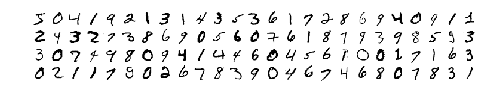

Epoch 0 : Sampling Image: 


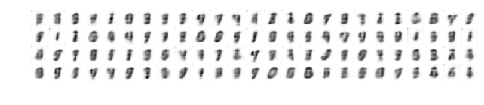

Epoch 0 : Reconstruct Image: 


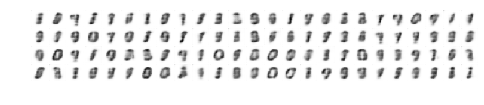

[1/10] - ptime: 19.01 Total_loss=(L+KL): 0.294 = (0.283+0.011)
Epoch 1 : Sampling Image: 


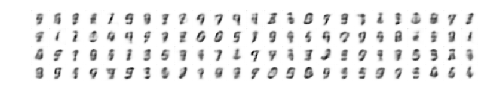

Epoch 1 : Reconstruct Image: 


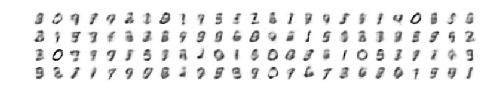

[2/10] - ptime: 17.77 Total_loss=(L+KL): 0.249 = (0.230+0.019)
Epoch 2 : Sampling Image: 


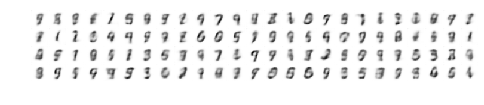

Epoch 2 : Reconstruct Image: 


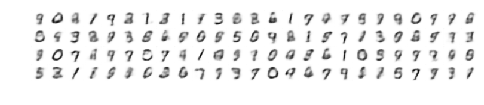

[3/10] - ptime: 17.66 Total_loss=(L+KL): 0.243 = (0.220+0.024)
Epoch 3 : Sampling Image: 


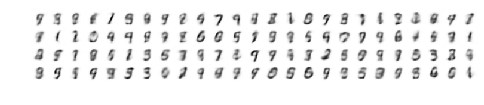

Epoch 3 : Reconstruct Image: 


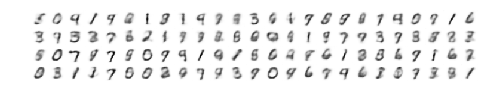

[4/10] - ptime: 17.68 Total_loss=(L+KL): 0.240 = (0.214+0.026)
Epoch 4 : Sampling Image: 


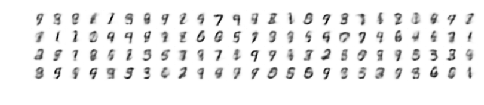

Epoch 4 : Reconstruct Image: 


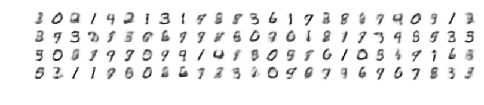

[5/10] - ptime: 17.68 Total_loss=(L+KL): 0.238 = (0.210+0.028)
Epoch 5 : Sampling Image: 


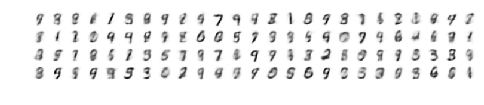

Epoch 5 : Reconstruct Image: 


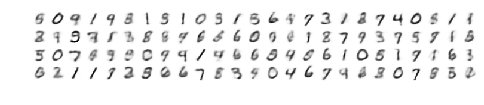

[6/10] - ptime: 17.67 Total_loss=(L+KL): 0.236 = (0.207+0.029)
Epoch 6 : Sampling Image: 


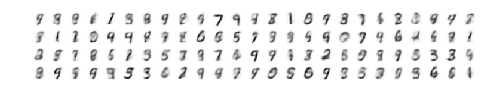

Epoch 6 : Reconstruct Image: 


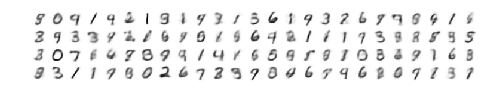

[7/10] - ptime: 17.67 Total_loss=(L+KL): 0.234 = (0.204+0.030)
Epoch 7 : Sampling Image: 


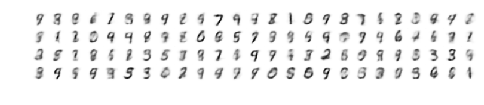

Epoch 7 : Reconstruct Image: 


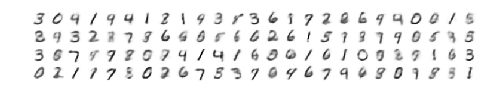

[8/10] - ptime: 17.68 Total_loss=(L+KL): 0.233 = (0.202+0.031)
Epoch 8 : Sampling Image: 


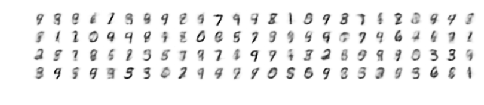

Epoch 8 : Reconstruct Image: 


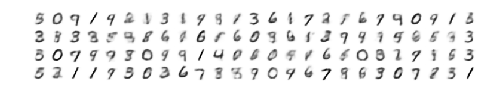

[9/10] - ptime: 17.68 Total_loss=(L+KL): 0.232 = (0.200+0.031)
Epoch 9 : Sampling Image: 


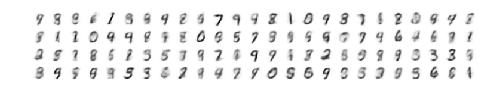

Epoch 9 : Reconstruct Image: 


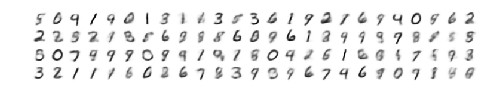

[10/10] - ptime: 17.68 Total_loss=(L+KL): 0.231 = (0.199+0.032)


In [2]:
mnist = tf.keras.datasets.mnist
(data, _), (_,_) = mnist.load_data()

with tf.Session() as sess:
    vae = VAE(sess,image_size=28,z_dim=200,device_name="gpu")
    vae.train(data, num_epoch=10, lr=0.0002, beta1=0.5)